## Missing data and imputation
In this notebook, we conduct a simple experiment to highlight advantages
and disadvantages of methods for data imputation.
We will benchmark mean / mode / median / constant imputation as well as
a k-NN-based hot-deck imputation and MICE.

In [1]:
"""Sandbox for notebook"""
# base imports
import os
import time

# exploratory data analysis
# import missingno, pandas_profiling

# data processing
import numpy as np
import pandas as pd

# datasets/training/imputation
import sklearn
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# autoML
# import h2o
# from h2o.automl import H2OAutoML

# imputation
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# import impyute, fancyimpute, autoimpute, missingpy, datawig
from fancyimpute import KNN
from missingpy import MissForest
# from datawig import SimpleImputer as DWSimpleImputer

# progress bar
from tqdm.notebook import tqdm
# visualisation
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


Some settings + seed

In [2]:
# project base path
try:
    # inside try to be able to easily run stuff on ipython as well
    BASE_DIR = os.path.join(os.path.abspath(os.path.dirname(__file__)), "..")
except NameError:
    BASE_DIR = ".."

# plot styling
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]
sns.set_context("talk")
sns.set_style("darkgrid", {"legend.frameon": True})

# set global seed for reproducible experiments
np.random.seed(0)

Utility functions for loading different data sets


In [3]:
def load_data(dataset="breast_cancer"):
    
    data_dict = {"iris": lambda: datasets.load_iris(),
                 "diabetes": lambda: datasets.load_diabetes(),
                 "digits": lambda: datasets.load_digits(),
                 "breast_cancer": lambda: datasets.load_breast_cancer()}

    data = data_dict[dataset]()
    df = pd.DataFrame(data.data)
    if "feature_names" in data:
        df.columns = data.feature_names

    df["target"] = data.target
    return df.iloc[:, :-1], df.iloc[:, -1]


def load_wine():
    df = pd.read_csv(os.path.join(BASE_DIR, "data", "winequality-white.csv"), sep=";")
    # df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", sep=";")
    return df.iloc[:, :-1], df.iloc[:, -1]

def load_census():

    CAT = "category"
    CONT = np.float32

    col_names = [
        "age",
        "workclass",
        "fnlwgt",
        "education",
        "education_num",
        "marital",
        "occupation",
        "relationship",
        "race",
        "sex",
        "capital_gain",
        "capital_loss",
        "hours_per_week",
        "native_country",
        ">50k",
    ]

    dtypes = [
        np.int16,
        CAT,
        CONT,
        CAT,
        CONT,
        CAT,
        CAT,
        CAT,
        CAT,
        CAT,
        CONT,
        CONT,
        CONT,
        CAT,
        CAT,
    ]
    df = pd.read_csv(
        os.path.join(BASE_DIR, "data", "adult.data"),
        # "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
        sep=",",
        names=col_names,
        dtype={k: v for (k, v) in zip(col_names, dtypes)},
    )
    
    return df.iloc[:, :-1], df.iloc[:, -1]


Methods for deleting points - both MCAR and MAR

In [4]:
# introduce missingness - missing completely at random
def delete_datapoints(X, y, columns=None, frac=0.1, missingness="mcar"):
    
    _X = X.copy(deep=True)
    _y = y.copy(deep=True)
    
    if frac == 0:
        return _X
    
    if columns is None:
        columns = _X.columns

    if isinstance(columns, str):
        columns = [columns]    

    if missingness == "mcar":
        for col in columns:
            nan_idx = _X.sample(frac=frac).index
            _X.loc[nan_idx, col] = np.NaN
    else:
        # set different fractions of missing data depending on the median of the response variable
        # _X.index = _y.index
        for col in columns:
            nan_idx_1 = _X[y >= np.nanmedian(y)].sample(frac=max(frac - 0.15, 0)).index.to_list()
            nan_idx_2 = _X[y < np.nanmedian(y)].sample(frac=min(frac + 0.15, 1)).index.to_list()
            indices = nan_idx_1 + nan_idx_2
            _X.loc[indices, col] = np.NaN

    return _X

Function for data imputation:

In [5]:
def impute_data(X, columns=None, strategy="mean", **strategy_kwargs):
    _X = X.copy(deep=True)
    
    # early return if none missing to avoid warnings 
    if not _X.isna().any(axis=None):
        return _X

    # complete case is not really an imputation strategy...
    if strategy == "complete_case":
        return _X.dropna()
    
    cat_vars = strategy_kwargs.pop("cat_vars", None)
    estimator = strategy_kwargs.pop("estimator", None)

    strategy_dict = {
        # use lambda to avoid premature initialisation
        "mean": lambda: SimpleImputer(missing_values=np.NaN, strategy="mean"),
        "median": lambda: SimpleImputer(missing_values=np.NaN, strategy="median"),
        "most_frequent": lambda: SimpleImputer(
            missing_values=np.NaN, strategy="most_frequent"
        ),
        "zero": lambda: SimpleImputer(
            missing_values=np.NaN, strategy="constant", fill_value=0
        ),
        "knn": lambda: KNN(**strategy_kwargs),
        "mice": lambda: IterativeImputer(
            estimator=estimator,
            max_iter=10, 
            sample_posterior=estimator is None, 
            **strategy_kwargs
        ),
        "miss-forest": lambda: MissForest(max_iter=10, **strategy_kwargs),
        # "datawig": lambda: DWSimpleImputer
    }

    if columns is None:
        columns = _X.columns

    imputer = strategy_dict[strategy]()

    if strategy == "datawig":
        _X = imputer.complete(_X)
    elif strategy == "miss-forest":
        imputer.fit(_X.loc[:, columns], cat_vars=cat_vars)
        _X.loc[:, columns] = imputer.transform(_X)
    else:
        _X.loc[:, columns] = imputer.fit_transform(_X.loc[:, columns])
    return _X

Benchmarking experiment code:

In [6]:
def experiment(
    X,
    y,
    model=None,
    metric=None,
    reps=3,
    missing_fracs=None,
    impute_params=None,
    missingness="mcar",
):

    if missing_fracs is None:
        missing_fracs = np.linspace(0.0, 0.9, 5)

    if impute_params is None:
        impute_params = [
            ("complete_case", {}),
            ("mean", {}),
            ("median", {}),
            ("most_frequent", {}),
            ("zero", {}),
            ("knn", {"k": 3, "verbose": False}),
            ("mice", {}),
            # ("miss-forest", {"n_estimators": 100}),
            # ("datawig", {})
        ]

    results = {"exp_rep": [], "missing_frac": [], "strategy": [], "metric_score": []}

    # print("Split into train and validation set")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    # print("Evaluating different imputation methods w.r.t. model accuracy")

    for rep in range(reps):
        # print("\n\n========== Experiment instance %s ==========" % rep)
        for missing_frac in tqdm(missing_fracs):
            # print(
            #     "\n========== Missing percentage %s%% =========="
            #     % int(missing_frac * 100)
            # )
            # print("Introducing %s missingness" %(missingness))
            X_train_miss = delete_datapoints(X_train, y_train, frac=missing_frac, missingness=missingness)

            for (impute_strategy, impute_param) in impute_params:
                # print("========== Imputation strategy %s ==========" % impute_strategy)
                try:
                    X_train_imputed = impute_data(
                        X_train_miss, strategy=impute_strategy, **impute_param
                    )
                    y_train_imputed = y_train.loc[X_train_imputed.index]

                    # print("Retrain model on imputed data")
                    model.fit(X_train_imputed, y_train_imputed)
                    # make use of metric
                    y_pred = model.predict(X_test)
                    metric_score = metric(y_test, y_pred)
                except ValueError as e:
                    # print(
                    #     "Could not train model or compute accuracy. Continue to next training instance."
                    # )
                    # print(e)
                    continue
                # print("Metric score: %s" % metric_score)

                results["exp_rep"].append(rep)
                results["missing_frac"].append(missing_frac)
                results["strategy"].append(impute_strategy)
                results["metric_score"].append(metric_score)

    return pd.DataFrame(results)

Some utility function for plotting:

In [7]:
def feature_col_vs_metric_score(
    results_df,
    feature_col="missing_frac",
    metric_score="metric_score",
    group_col="strategy",
):
    """
    How does each model perform based on a single feature (averaged across other relevant features) wrt a metric score
    :param group_col:
    :param results_df:
    :param feature_col:
    :param metric_score:
    :return:
    """
    return sns.lineplot(
        x=feature_col,
        y=metric_score,
        hue=group_col,
        style=group_col,
        markers=True,
        dashes=False,
        data=results_df,
    )

### Experiment no. 1: Wine dataset with simple linear regression (MCAR & MAR).

In [8]:
X, y = load_wine()
print("Design matrix")
print(X.shape)
print(X.head())
print("\nTarget")
print(y.head())

Design matrix
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  
0      8.8  
1      9.5  
2     10.1  
3      9.9  
4      

In [9]:
model = LinearRegression()
metric = metrics.mean_squared_error
missing_fracs = np.linspace(0.0, 0.9, 10)

wine_results_mcar = experiment(
    X,
    y,
    model=model,
    metric=metric,
    reps=1,
    missing_fracs=missing_fracs,
    impute_params = [
            ("complete_case", {}),
            ("mean", {}),
            ("median", {}),
            # ("most_frequent", {}),
            # ("zero", {}),
            ("knn", {"k": 3, "verbose": False}),
            ("mice", {}),
        ],
    missingness="mcar",
)


In [10]:
model = LinearRegression()
metric = metrics.mean_squared_error
missing_fracs = np.linspace(0.0, 0.9, 10)

wine_results_mar = experiment(
    X,
    y,
    model=model,
    metric=metric,
    reps=1,
    missing_fracs=missing_fracs,
    impute_params = [
            ("complete_case", {}),
            ("mean", {}),
            ("median", {}),
            # ("most_frequent", {}),
            # ("zero", {}),
            ("knn", {"k": 3, "verbose": False}),
            ("mice", {}),
        ],
    missingness="mar",
)


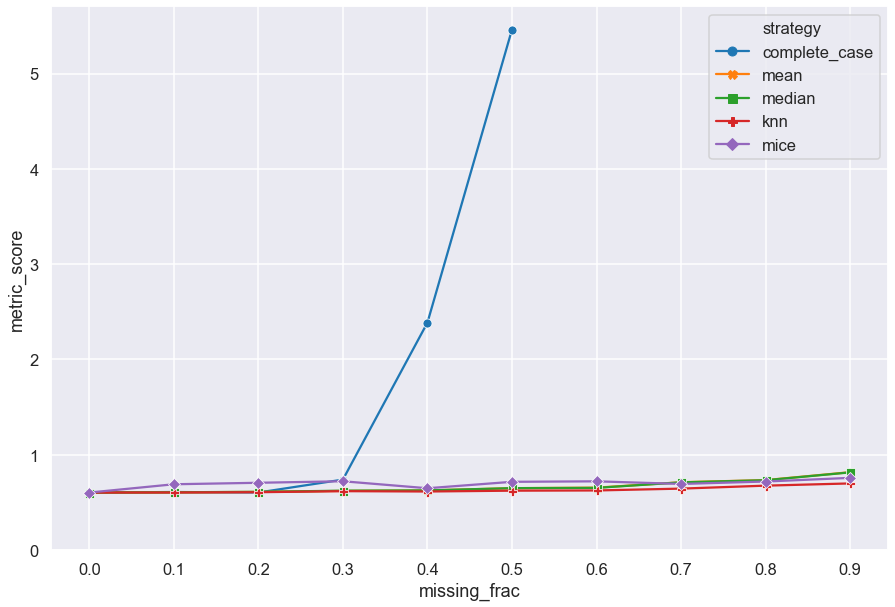

In [11]:
feature_col_vs_metric_score(wine_results_mcar)
# feature_col_vs_metric_score(wine_results_mcar[~wine_results_mcar['strategy'].isin(["complete_case"])])
plt.gca().set_ylim(bottom=0)
plt.xticks(missing_fracs)
plt.show()

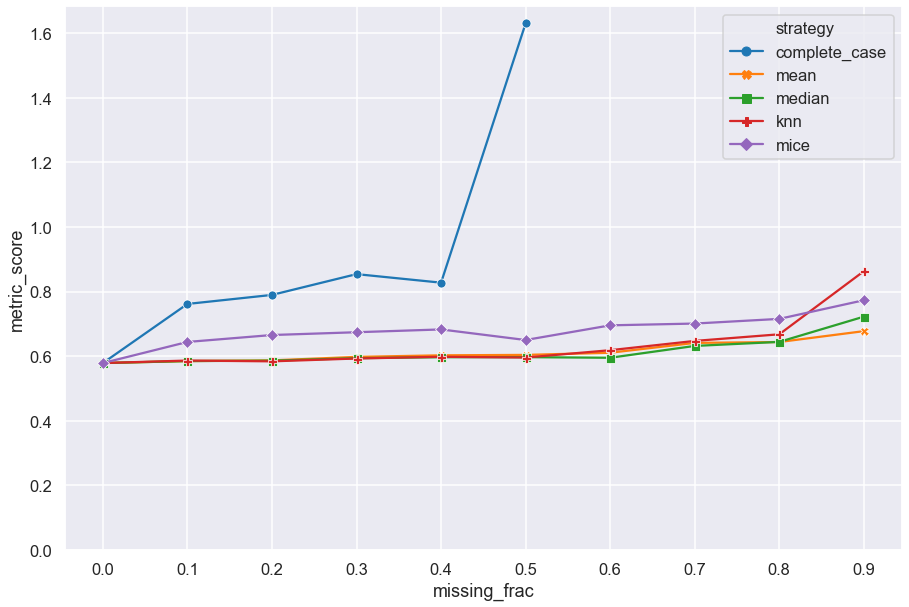

In [12]:
feature_col_vs_metric_score(wine_results_mar)
# feature_col_vs_metric_score(wine_results_mar[~wine_results_mar['strategy'].isin(["complete_case", "zero"])])
plt.gca().set_ylim(bottom=0)
plt.xticks(missing_fracs)
plt.show()

### Experiment no. 2: Breast cancer dataset with random forest (MCAR & MAR).

In [46]:
X, y = load_data("breast_cancer")
print("Design matrix")
X = X.iloc[:, :10]
print(X.shape)
print(X.head())
print("\nTarget")
print(y.head())


Design matrix
(569, 10)
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  
0                 0.07871  
1           

In [47]:
model = RandomForestClassifier(n_estimators=40)
metric = metrics.accuracy_score
missing_fracs = np.linspace(0.0, 0.9, 10)

breast_cancer_results_rf_mcar = experiment(
    X,
    y,
    model=model,
    metric=metric,
    reps=1,
    missing_fracs=missing_fracs,
    impute_params = [
            ("complete_case", {}),
            ("mean", {}),
            ("median", {}),
            # ("most_frequent", {}),
            # ("zero", {}),
            ("knn", {"k": 3, "verbose": False}),
            ("mice", {}),
        ],
    missingness="mcar",
)

In [48]:
model = RandomForestClassifier(n_estimators=40)
metric = metrics.accuracy_score
missing_fracs = np.linspace(0.0, 0.9, 10)

breast_cancer_results_rf_mar = experiment(
    X,
    y,
    model=model,
    metric=metric,
    reps=1,
    missing_fracs=missing_fracs,
    impute_params = [
            ("complete_case", {}),
            ("mean", {}),
            ("median", {}),
            # ("most_frequent", {}),
            # ("zero", {}),
            ("knn", {"k": 3, "verbose": False}),
            ("mice", {}),
        ],
    missingness="mar",
)

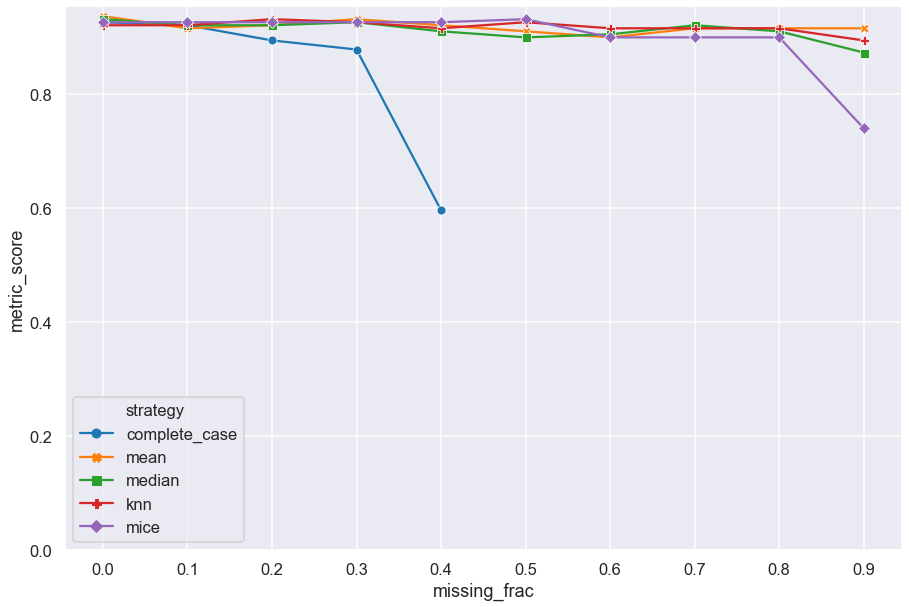

In [49]:
feature_col_vs_metric_score(breast_cancer_results_rf_mcar)
plt.gca().set_ylim(bottom=0)
plt.xticks(missing_fracs)
plt.show()

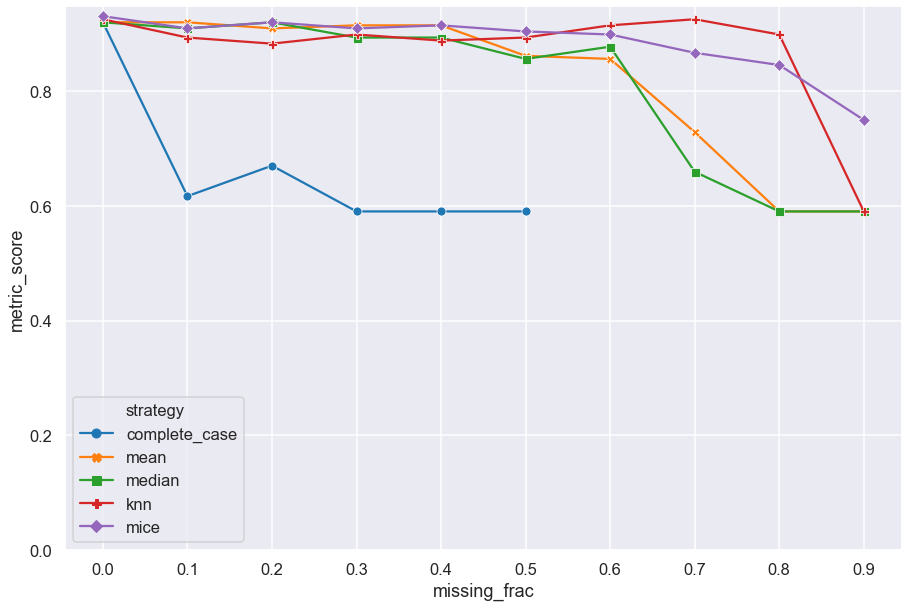

In [50]:
feature_col_vs_metric_score(breast_cancer_results_rf_mar)
plt.gca().set_ylim(bottom=0)
plt.xticks(missing_fracs)
plt.show()

### Experiment no. 3: Census dataset with random forest (MCAR).

In [ ]:
X, y = load_census()

print("Design matrix")
print(X.shape)
print(X.head())
print("\nTarget")
print(y.head())

# X = X.sample(n=10000)
# y = y.loc[X.index]

In [ ]:
X = X[["age", "education", "occupation", "hours_per_week"]]
X = pd.get_dummies(X, drop_first=True)

print("========== After reduction ==========")
print("Design matrix")
print(X.shape)
print(X.head())

In [ ]:
cols = X.columns.to_list()
non_cat_names = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week",]
cat_names = list(set(cols) - set(non_cat_names))
cat_col_idx = [cols.index(cat_name) for cat_name in cat_names]

In [ ]:
model = RandomForestClassifier(n_estimators=100)
metric = metrics.accuracy_score
missing_fracs = np.linspace(0.0, 0.9, 5)

census_results_mcar = experiment(
    X,
    y,
    model=model,
    metric=metric,
    reps=1,
    missing_fracs=missing_fracs,
    impute_params = [
            ("complete_case", {}),
            # ("mean", {}),
            # ("median", {}),
            ("most_frequent", {}),
            # ("zero", {}),
            ("knn", {"k": 3, "verbose": False}),
            ("mice", {}),
            ("miss-forest", {"n_estimators": 100, "cat_vars": cat_col_idx}),
        ],
    missingness="mcar",
)

In [ ]:
feature_col_vs_metric_score(census_results_mcar)
plt.gca().set_ylim(bottom=0)
plt.xticks(missing_fracs)
plt.show()